# Multi-Factor Research with Alphalens

This notebook demonstrates advanced factor research:
- Building and testing multiple factors simultaneously
- Creating composite factors from individual signals
- Comparing factor performance
- Building a multi-factor ranking system

This is how professional quant researchers develop systematic strategies.

In [1]:
# Register Sharadar bundle (required for Jupyter notebooks)
from zipline.data.bundles import register
from zipline.data.bundles.sharadar_bundle import sharadar_bundle

register('sharadar', sharadar_bundle(tickers=None, incremental=True, include_funds=True))
print("✓ Sharadar bundle registered")

✓ Sharadar bundle registered


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

try:
    import alphalens as al
    print("✓ Alphalens imported")
except ImportError:
    print("⚠️  Install: pip install alphalens-reloaded")
    raise

from zipline.pipeline import Pipeline, CustomFactor
from zipline.pipeline.data import USEquityPricing
from zipline.pipeline.factors import AverageDollarVolume, Returns, RSI
from zipline.data.bundles import load
from zipline.utils.calendar_utils import get_calendar
from zipline.pipeline.engine import SimplePipelineEngine
from zipline.pipeline.loaders import USEquityPricingLoader

plt.rcParams['figure.figsize'] = (14, 8)
sns.set_style('darkgrid')

print("✓ Imports complete")

✓ Alphalens imported
✓ Imports complete


## Setup Pipeline Environment

In [3]:
bundle_data = load('sharadar')
trading_calendar = get_calendar('XNYS')

pricing_loader = USEquityPricingLoader.without_fx(
    bundle_data.equity_daily_bar_reader,
    bundle_data.adjustment_reader,
)

engine = SimplePipelineEngine(
    get_loader=lambda column: pricing_loader,
    asset_finder=bundle_data.asset_finder,
)

print("✓ Pipeline engine initialized")

✓ Pipeline engine initialized


## Define Multiple Factors

We'll create several factors representing different investment styles:
- **Momentum**: Trend-following
- **Mean Reversion**: Contrarian
- **Volatility**: Risk factor
- **Value**: RSI-based value signal

In [4]:
class Momentum(CustomFactor):
    """
    Price momentum: 60-day return.
    """
    inputs = [USEquityPricing.close]
    window_length = 60
    
    def compute(self, today, assets, out, close):
        out[:] = (close[-1] - close[0]) / close[0]


class ShortTermMomentum(CustomFactor):
    """
    Short-term momentum: 20-day return.
    """
    inputs = [USEquityPricing.close]
    window_length = 20
    
    def compute(self, today, assets, out, close):
        out[:] = (close[-1] - close[0]) / close[0]


class MeanReversion(CustomFactor):
    """
    Mean reversion: % deviation from 20-day MA.
    """
    inputs = [USEquityPricing.close]
    window_length = 20
    
    def compute(self, today, assets, out, close):
        ma = np.mean(close, axis=0)
        out[:] = (close[-1] - ma) / ma


class Volatility(CustomFactor):
    """
    Price volatility: std dev of returns.
    """
    inputs = [USEquityPricing.close]
    window_length = 20
    
    def compute(self, today, assets, out, close):
        returns = np.diff(close, axis=0) / close[:-1]
        out[:] = np.std(returns, axis=0)


print("✓ Factors defined")

✓ Factors defined


## Create Multi-Factor Pipeline

Compute all factors simultaneously for our universe.

In [5]:
def make_multi_factor_pipeline():
    """
    Pipeline that computes multiple factors.
    """
    # Calculate raw factors
    momentum = Momentum()
    short_momentum = ShortTermMomentum()
    mean_reversion = MeanReversion()
    volatility = Volatility()
    rsi_factor = RSI()
    
    # Universe: top 500 liquid stocks
    dollar_volume = AverageDollarVolume(window_length=30)
    universe = dollar_volume.top(500)
    
    # Normalize factors to z-scores (for combining)
    momentum_z = momentum.zscore(mask=universe)
    short_momentum_z = short_momentum.zscore(mask=universe)
    mean_reversion_z = mean_reversion.zscore(mask=universe)
    volatility_z = volatility.zscore(mask=universe)
    rsi_z = rsi_factor.zscore(mask=universe)
    
    # Composite factor: Combine momentum and low volatility
    momentum_quality = momentum_z - volatility_z
    
    # Another composite: Momentum + Mean Reversion (momentum with pullback)
    momentum_pullback = momentum_z - 0.5 * mean_reversion_z
    
    return Pipeline(
        columns={
            # Raw factors
            'momentum': momentum,
            'short_momentum': short_momentum,
            'mean_reversion': mean_reversion,
            'volatility': volatility,
            'rsi': rsi_factor,
            # Normalized factors
            'momentum_z': momentum_z,
            'short_momentum_z': short_momentum_z,
            'mean_reversion_z': mean_reversion_z,
            'volatility_z': volatility_z,
            'rsi_z': rsi_z,
            # Composite factors
            'momentum_quality': momentum_quality,
            'momentum_pullback': momentum_pullback,
        },
        screen=universe
    )

print("✓ Multi-factor pipeline defined")

✓ Multi-factor pipeline defined


## Run Pipeline and Get Pricing Data

In [6]:
# Define research period - ensure dates are valid trading days
# Get the trading calendar sessions
all_sessions = trading_calendar.sessions

# Find valid trading dates around our desired range
desired_start = pd.Timestamp('2022-01-01')
desired_end = pd.Timestamp('2023-06-30')

# Get the first trading day on or after desired start
start_date = all_sessions[all_sessions >= desired_start][0]

# Get the last trading day on or before desired end  
end_date = all_sessions[all_sessions <= desired_end][-1]

print(f"Running pipeline from {start_date.date()} to {end_date.date()}...")
print(f"  (Adjusted to valid trading days)")

pipeline = make_multi_factor_pipeline()
factor_data = engine.run_pipeline(pipeline, start_date, end_date)

print(f"\n✓ Pipeline complete: {len(factor_data):,} observations")

# Get pricing data
assets = factor_data.index.get_level_values(1).unique()
pricing_end = all_sessions[all_sessions > end_date][29]  # ~30 days later

pricing_data = bundle_data.equity_daily_bar_reader.load_raw_arrays(
    columns=['close'],
    start_date=start_date,
    end_date=pricing_end,
    assets=assets,
)

dates = trading_calendar.sessions_in_range(start_date, pricing_end)
prices = pd.DataFrame(
    data=pricing_data[0],  # Already in correct shape (dates, assets), no transpose needed
    index=dates,
    columns=assets
)

print(f"✓ Pricing data loaded: {prices.shape}")

Running pipeline from 2022-01-03 to 2023-06-30...
  (Adjusted to valid trading days)

✓ Pipeline complete: 187,500 observations
✓ Pricing data loaded: (405, 823)


## Compare Individual Factors

Test each factor separately to see which ones are predictive.

In [7]:
# Factors to test
factors_to_test = [
    'momentum',
    'short_momentum',
    'mean_reversion',
    'volatility',
    'rsi',
]

# Store IC for each factor
factor_ics = {}

for factor_name in factors_to_test:
    print(f"\nAnalyzing {factor_name}...")
    
    factor = factor_data[factor_name]
    
    try:
        # Get clean factor data
        factor_clean = al.utils.get_clean_factor_and_forward_returns(
            factor=factor,
            prices=prices,
            quantiles=5,
            periods=(1, 5, 10),
            max_loss=0.35,
        )
        
        # Calculate IC
        ic = al.performance.factor_information_coefficient(factor_clean)
        factor_ics[factor_name] = ic
        
        print(f"  Mean IC (5D): {ic['5D'].mean():.4f}")
        print(f"  IC Std (5D): {ic['5D'].std():.4f}")
        print(f"  IC t-stat: {ic['5D'].mean() / ic['5D'].std() * np.sqrt(len(ic)):.2f}")
        
    except Exception as e:
        print(f"  Error: {e}")

print("\n✓ Individual factor analysis complete")


Analyzing momentum...
Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
  Mean IC (5D): -0.0176
  IC Std (5D): 0.2583
  IC t-stat: -1.32

Analyzing short_momentum...
Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
  Mean IC (5D): 0.0009
  IC Std (5D): 0.2360
  IC t-stat: 0.07

Analyzing mean_reversion...
Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
  Mean IC (5D): 0.0030
  IC Std (5D): 0.2318
  IC t-stat: 0.25

Analyzing volatility...
Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_lo

## Compare Factor Performance

Visualize IC for all factors side-by-side.

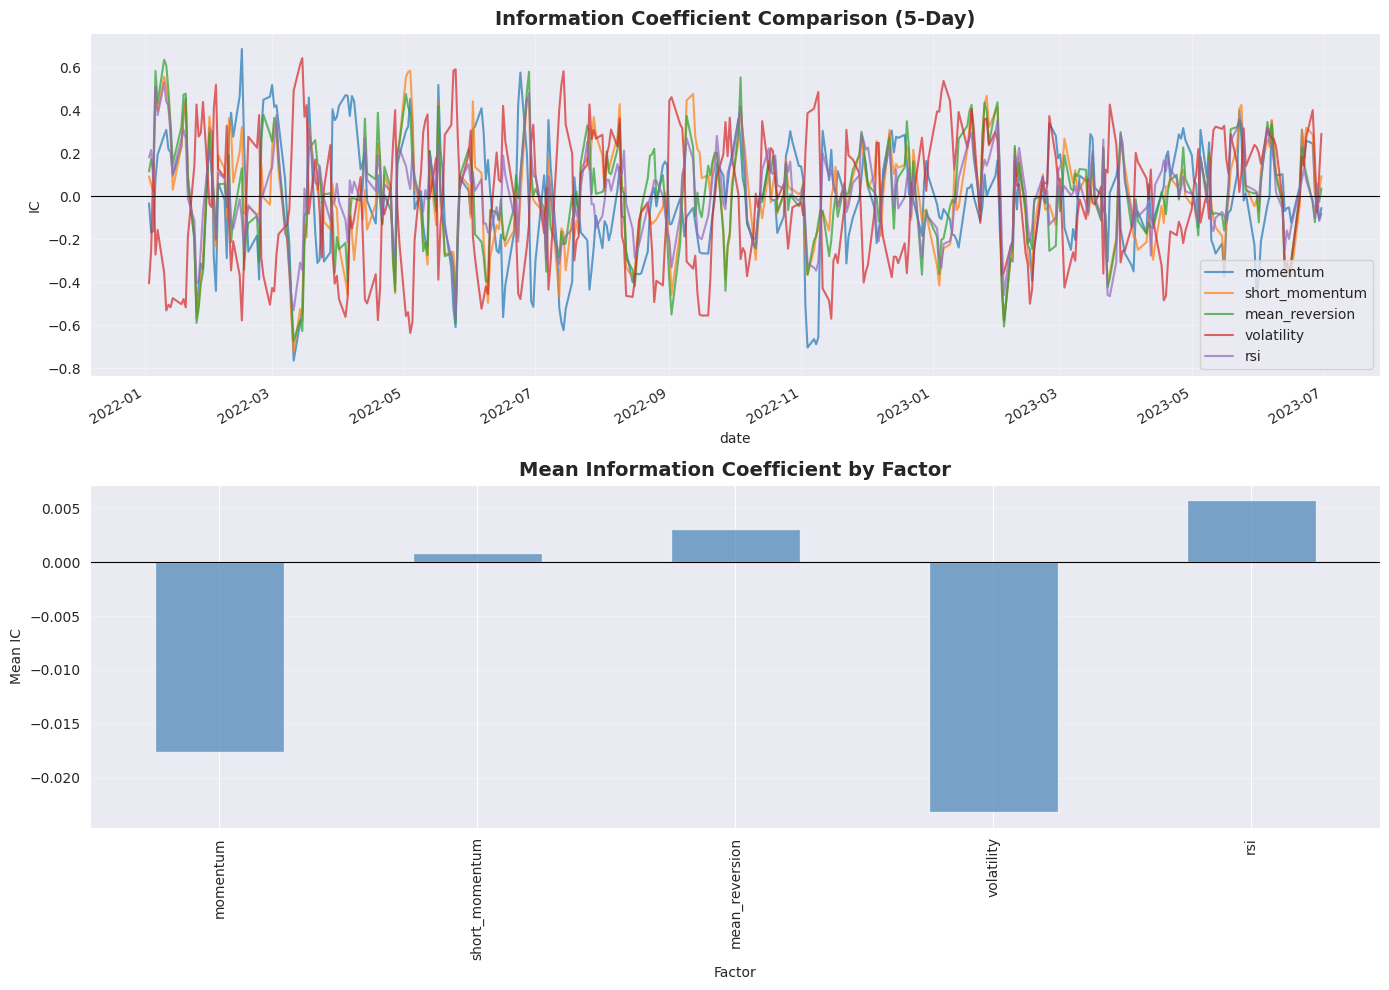


Factor IC Statistics:
                 Mean IC    IC Std  IR (Mean/Std)
rsi             0.005736  0.183812       0.031208
mean_reversion  0.003045  0.231773       0.013139
short_momentum  0.000857  0.235954       0.003632
momentum       -0.017570  0.258288      -0.068026
volatility     -0.023178  0.295936      -0.078321


In [8]:
# Combine all ICs
all_ics = pd.DataFrame({name: ic['5D'] for name, ic in factor_ics.items()})

# Plot IC comparison
fig, axes = plt.subplots(2, 1, figsize=(14, 10))

# IC over time
all_ics.plot(ax=axes[0], alpha=0.7)
axes[0].axhline(0, color='black', linestyle='-', linewidth=0.8)
axes[0].set_title('Information Coefficient Comparison (5-Day)', fontsize=14, fontweight='bold')
axes[0].set_ylabel('IC')
axes[0].legend(loc='best')
axes[0].grid(True, alpha=0.3)

# IC statistics (mean and std)
ic_stats = pd.DataFrame({
    'Mean IC': all_ics.mean(),
    'IC Std': all_ics.std(),
    'IR (Mean/Std)': all_ics.mean() / all_ics.std(),
})

ic_stats['Mean IC'].plot(kind='bar', ax=axes[1], color='steelblue', alpha=0.7)
axes[1].axhline(0, color='black', linestyle='-', linewidth=0.8)
axes[1].set_title('Mean Information Coefficient by Factor', fontsize=14, fontweight='bold')
axes[1].set_ylabel('Mean IC')
axes[1].set_xlabel('Factor')
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print("\nFactor IC Statistics:")
print("="*60)
print(ic_stats.sort_values('Mean IC', ascending=False))

## Analyze Composite Factors

Test our composite factors that combine multiple signals.


Analyzing Composite Factor: momentum_quality

Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Returns Analysis


1D     5D    10D
Ann. alpha                                     0.016  0.018  0.020
beta                                          -0.646 -0.561 -0.530
Mean Period Wise Return Top Quantile (bps)    -3.814 -3.837 -3.214
Mean Period Wise Return Bottom Quantile (bps) -1.764 -0.319 -1.185
Mean Period Wise Spread (bps)                 -2.050 -2.965 -1.553

<Figure size 1400x800 with 0 Axes>

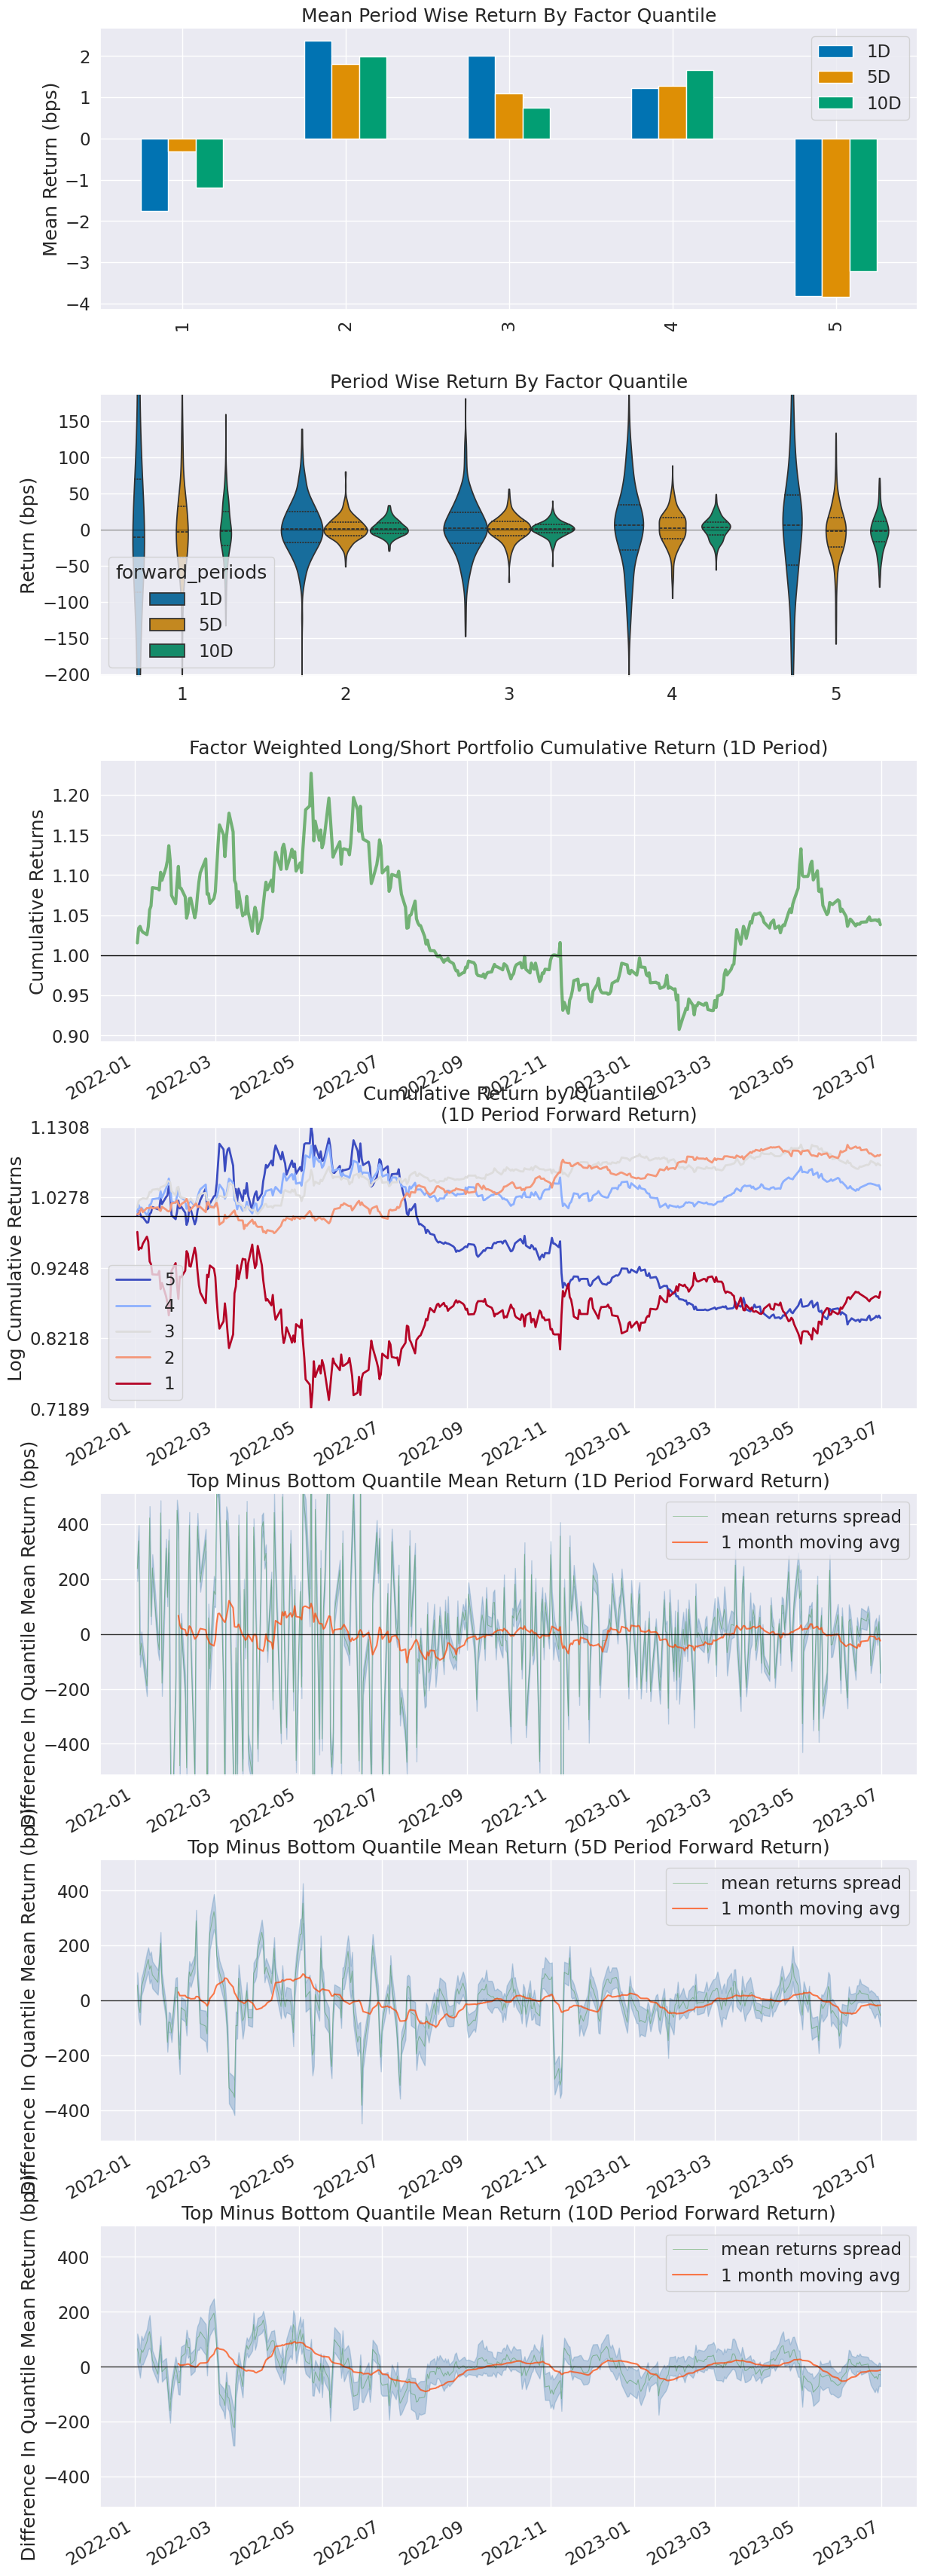


Analyzing Composite Factor: momentum_pullback

Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Returns Analysis


1D     5D    10D
Ann. alpha                                    -0.135 -0.158 -0.154
beta                                          -0.312 -0.232 -0.257
Mean Period Wise Return Top Quantile (bps)    -3.464 -4.650 -4.027
Mean Period Wise Return Bottom Quantile (bps)  4.396  5.204  3.429
Mean Period Wise Spread (bps)                 -7.860 -9.635 -7.297

<Figure size 1400x800 with 0 Axes>

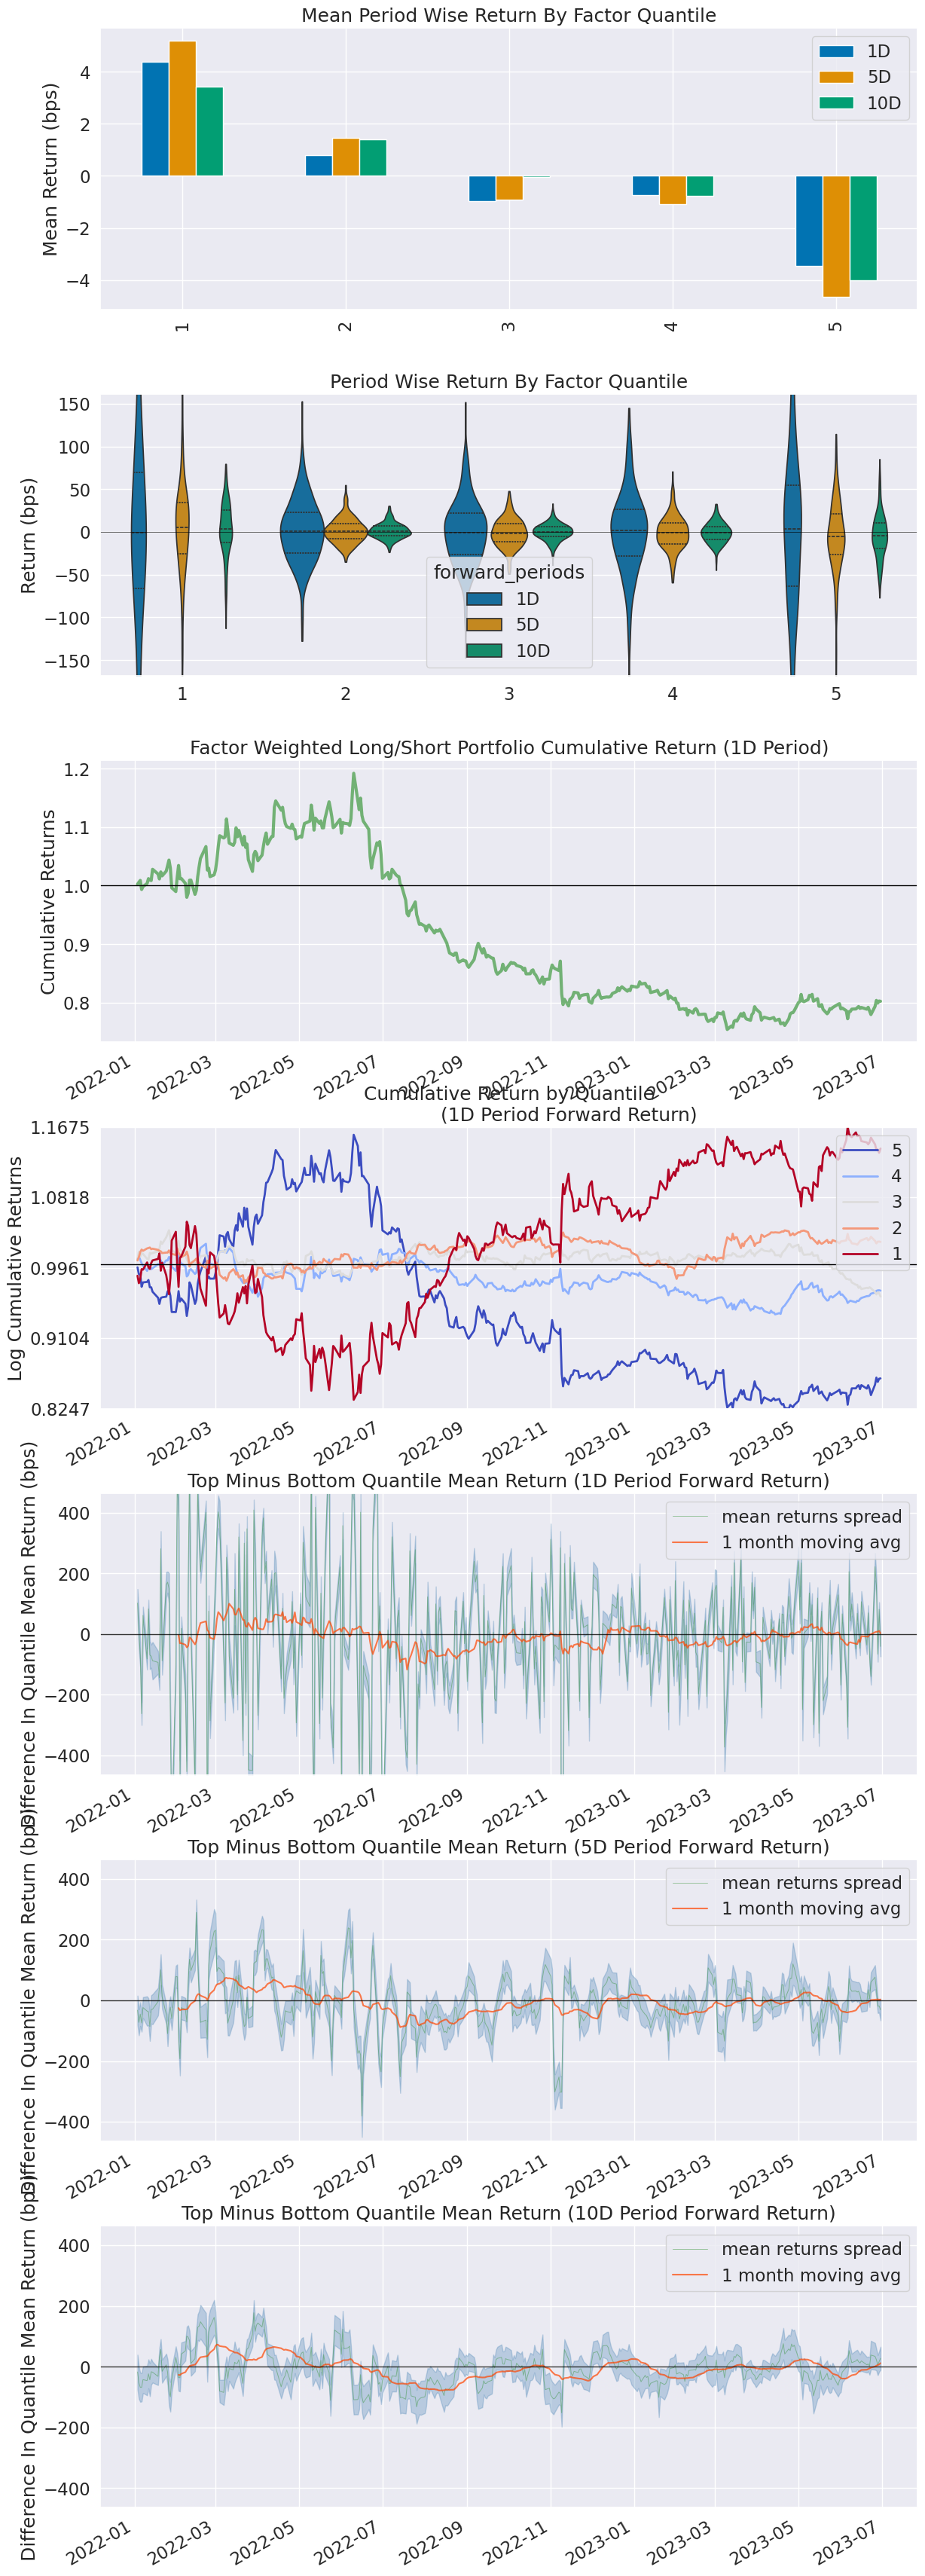

In [9]:
composite_factors = ['momentum_quality', 'momentum_pullback']

for factor_name in composite_factors:
    print(f"\n{'='*80}")
    print(f"Analyzing Composite Factor: {factor_name}")
    print(f"{'='*80}\n")
    
    factor = factor_data[factor_name]
    
    # Get clean factor data
    factor_clean = al.utils.get_clean_factor_and_forward_returns(
        factor=factor,
        prices=prices,
        quantiles=5,
        periods=(1, 5, 10),
        max_loss=0.35,
    )
    
    # Create returns tearsheet
    al.tears.create_returns_tear_sheet(factor_clean)

## Build a Combined Multi-Factor Score

Create a weighted combination of the best factors.

Multi-Factor Combined Score:
  Weights: {'momentum_z': 0.4, 'short_momentum_z': 0.2, 'volatility_z': -0.3, 'rsi_z': 0.1}

Analyzing combined factor...
Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!

COMBINED MULTI-FACTOR ANALYSIS

Quantiles Statistics


min       max      mean       std  count    count %
factor_quantile                                                          
1               -7.301077 -0.263006 -0.945113  0.636219  37500  20.009178
2               -0.566673  0.096088 -0.194249  0.113040  37479  19.997972
3               -0.141911  0.343228  0.081572  0.083020  37456  19.985700
4                0.077168  0.643482  0.307001  0.107535  37479  19.997972
5                0.258976  9.567746  0.753222  0.434859  37500  20.009178

Returns Analysis


1D     5D    10D
Ann. alpha                                    -0.001 -0.000  0.003
beta                                          -0.598 -0.490 -0.457
Mean Period Wise Return Top Quantile (bps)    -1.755 -2.269 -1.643
Mean Period Wise Return Bottom Quantile (bps) -1.323 -0.620 -0.474
Mean Period Wise Spread (bps)                 -0.431 -1.171 -0.786

<Figure size 1400x800 with 0 Axes>

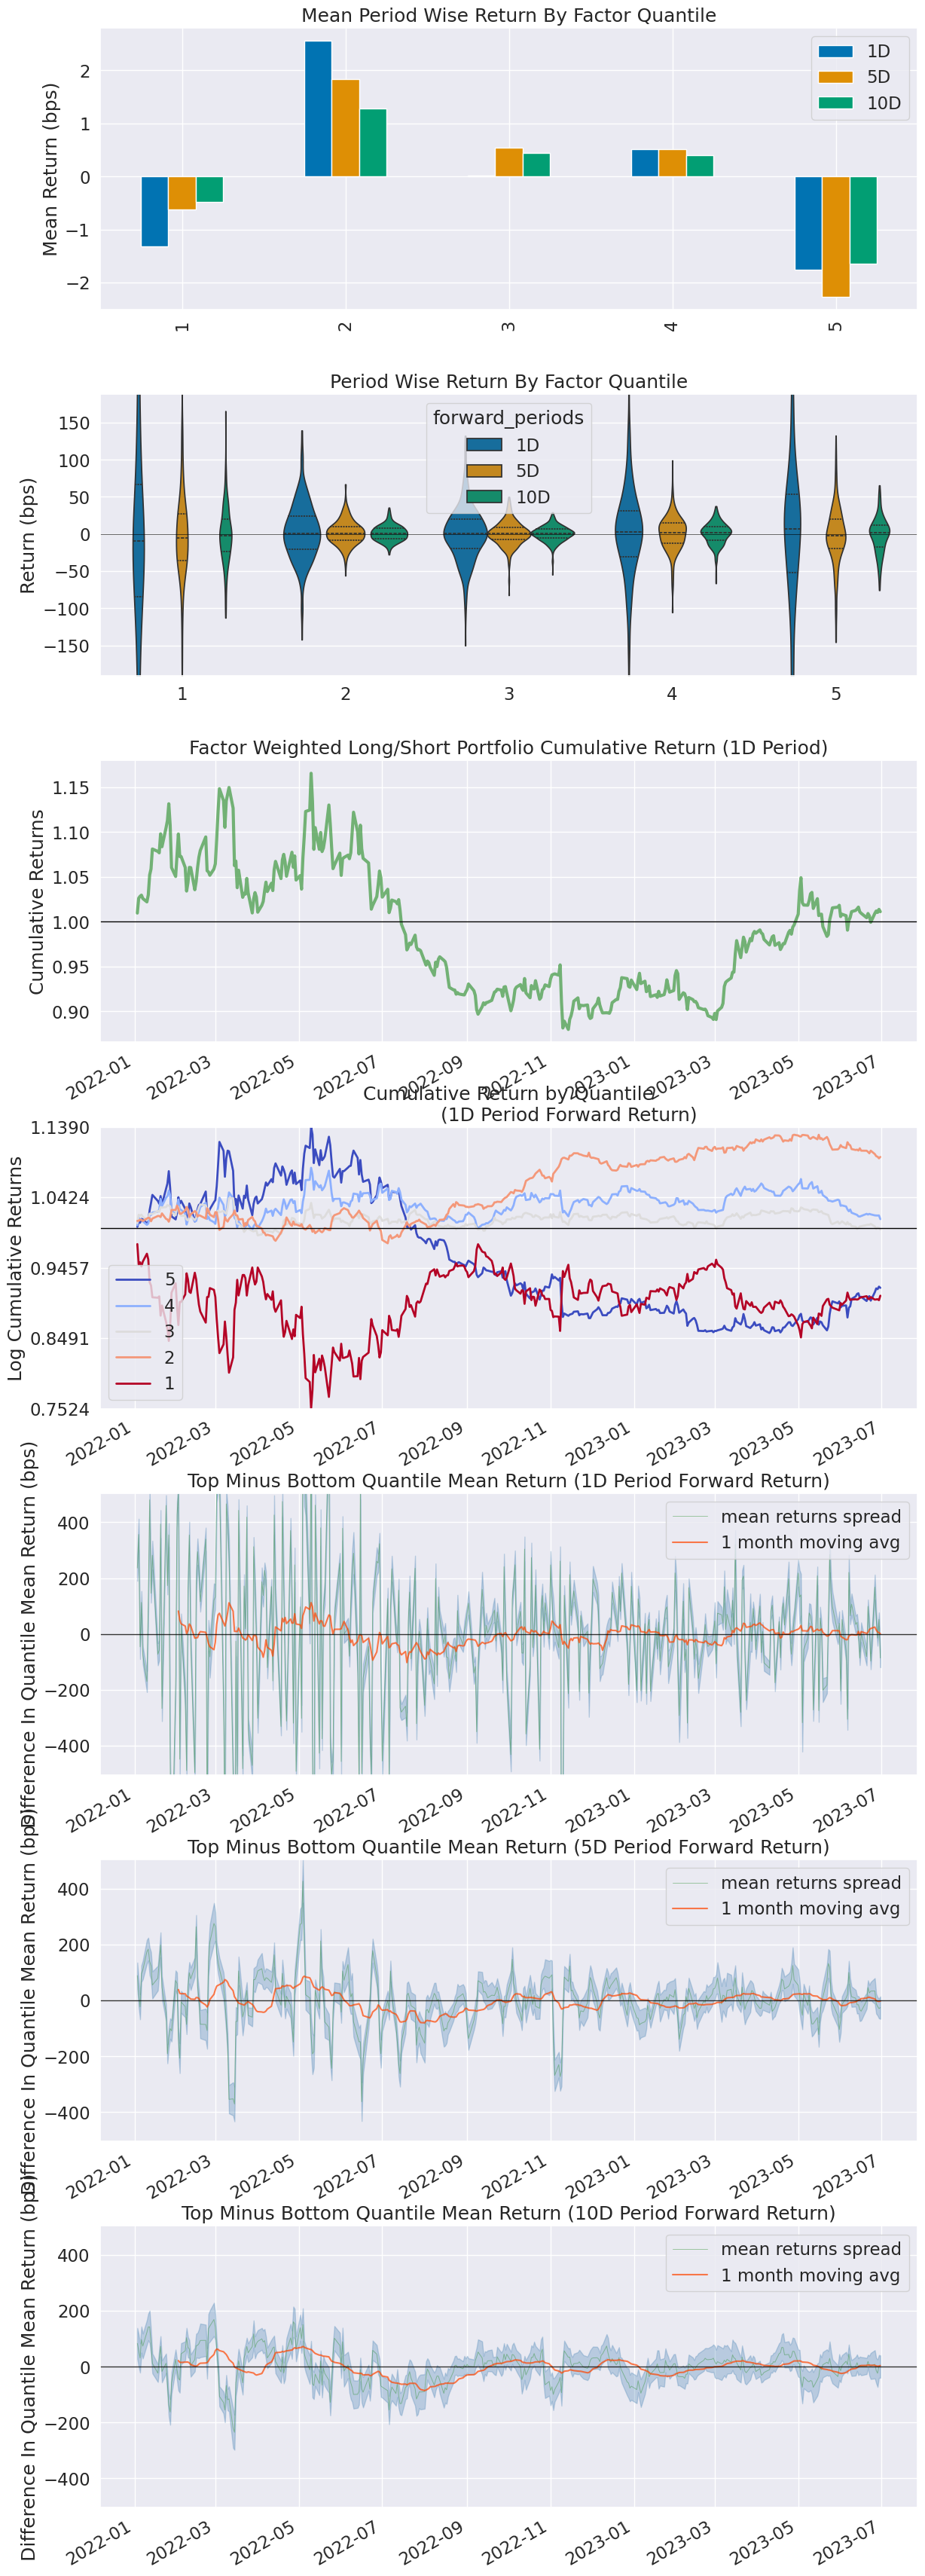

Information Analysis


1D     5D    10D
IC Mean           0.011  0.002  0.000
IC Std.           0.313  0.261  0.247
Risk-Adjusted IC  0.036  0.009  0.001
t-stat(IC)        0.690  0.173  0.012
p-value(IC)       0.490  0.863  0.990
IC Skew          -0.320 -0.256 -0.220
IC Kurtosis      -0.293 -0.038 -0.261

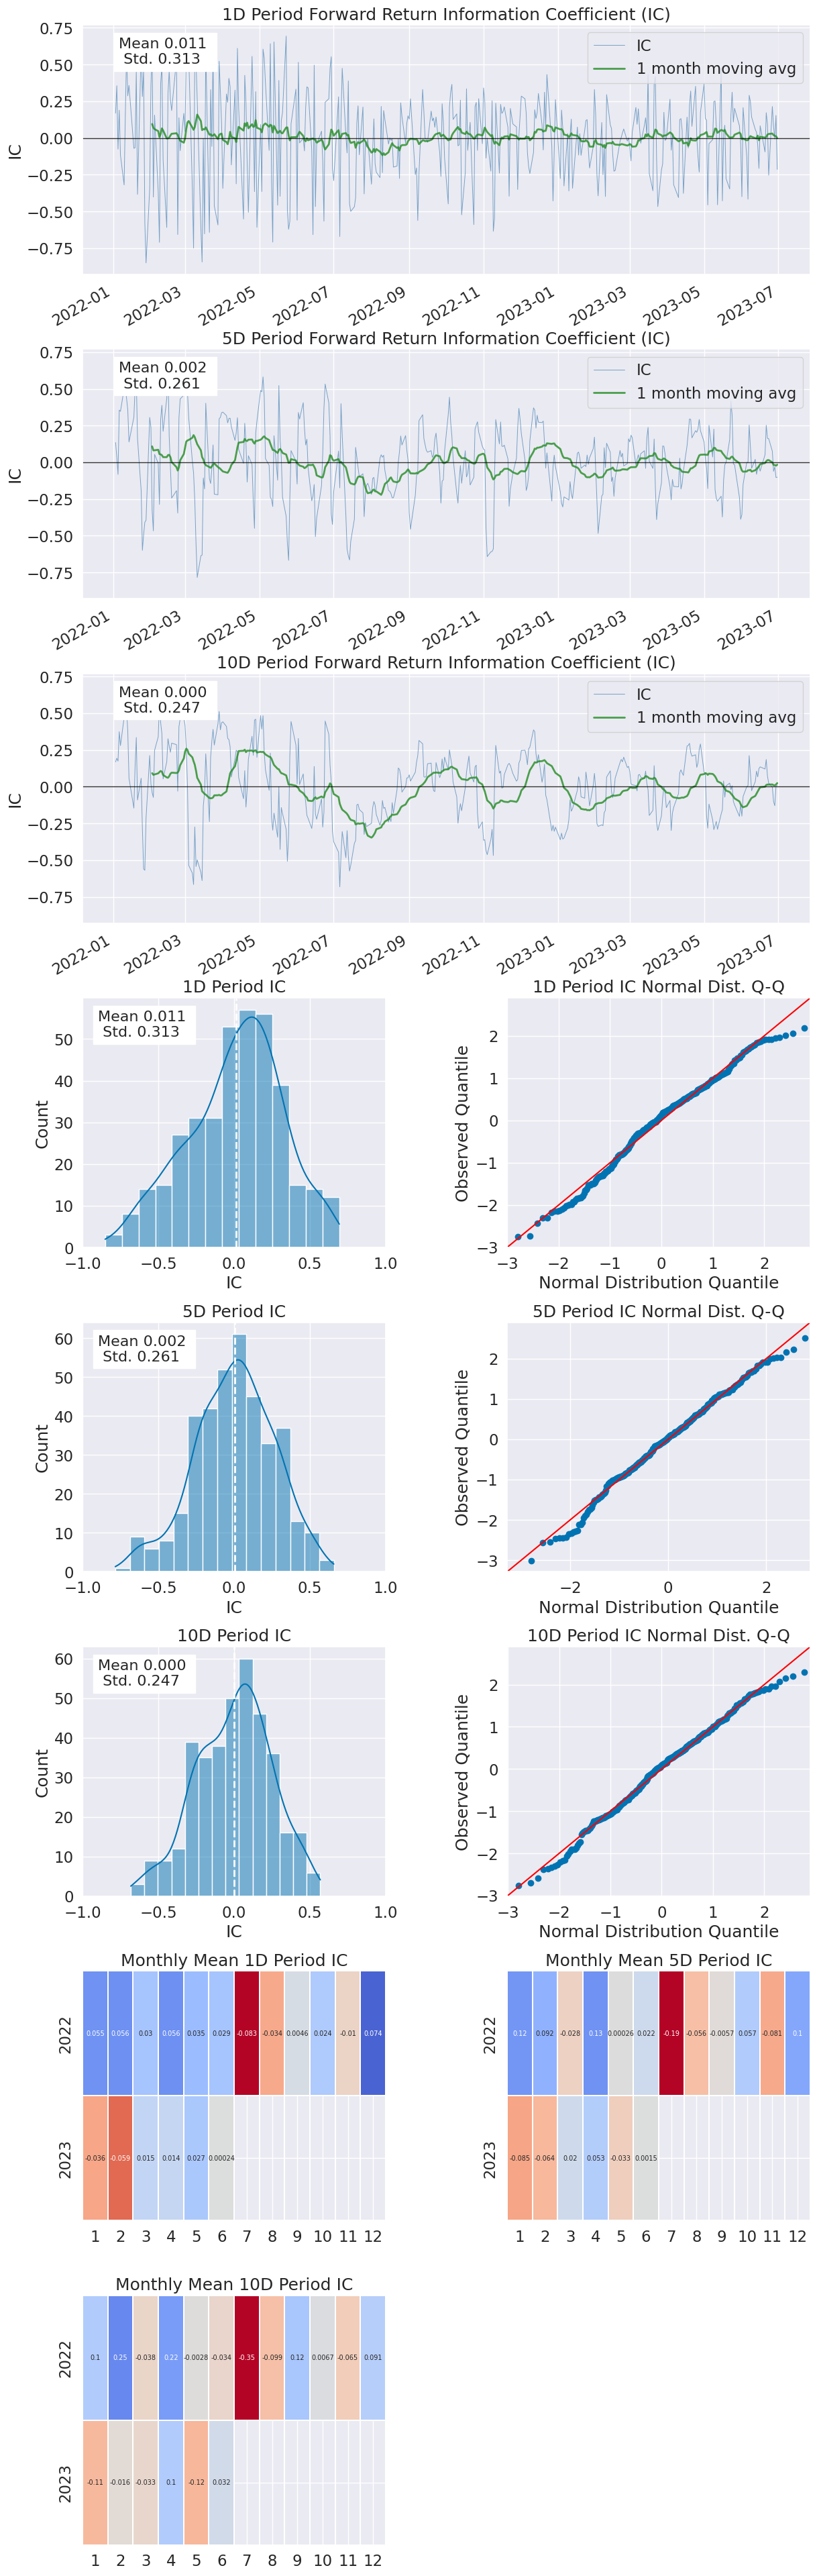

Turnover Analysis


1D     5D    10D
Quantile 1 Mean Turnover   0.100  0.242  0.360
Quantile 2 Mean Turnover   0.240  0.485  0.616
Quantile 3 Mean Turnover   0.300  0.550  0.658
Quantile 4 Mean Turnover   0.283  0.524  0.631
Quantile 5 Mean Turnover   0.136  0.315  0.453

1D     5D    10D
Mean Factor Rank Autocorrelation  0.967  0.848  0.708

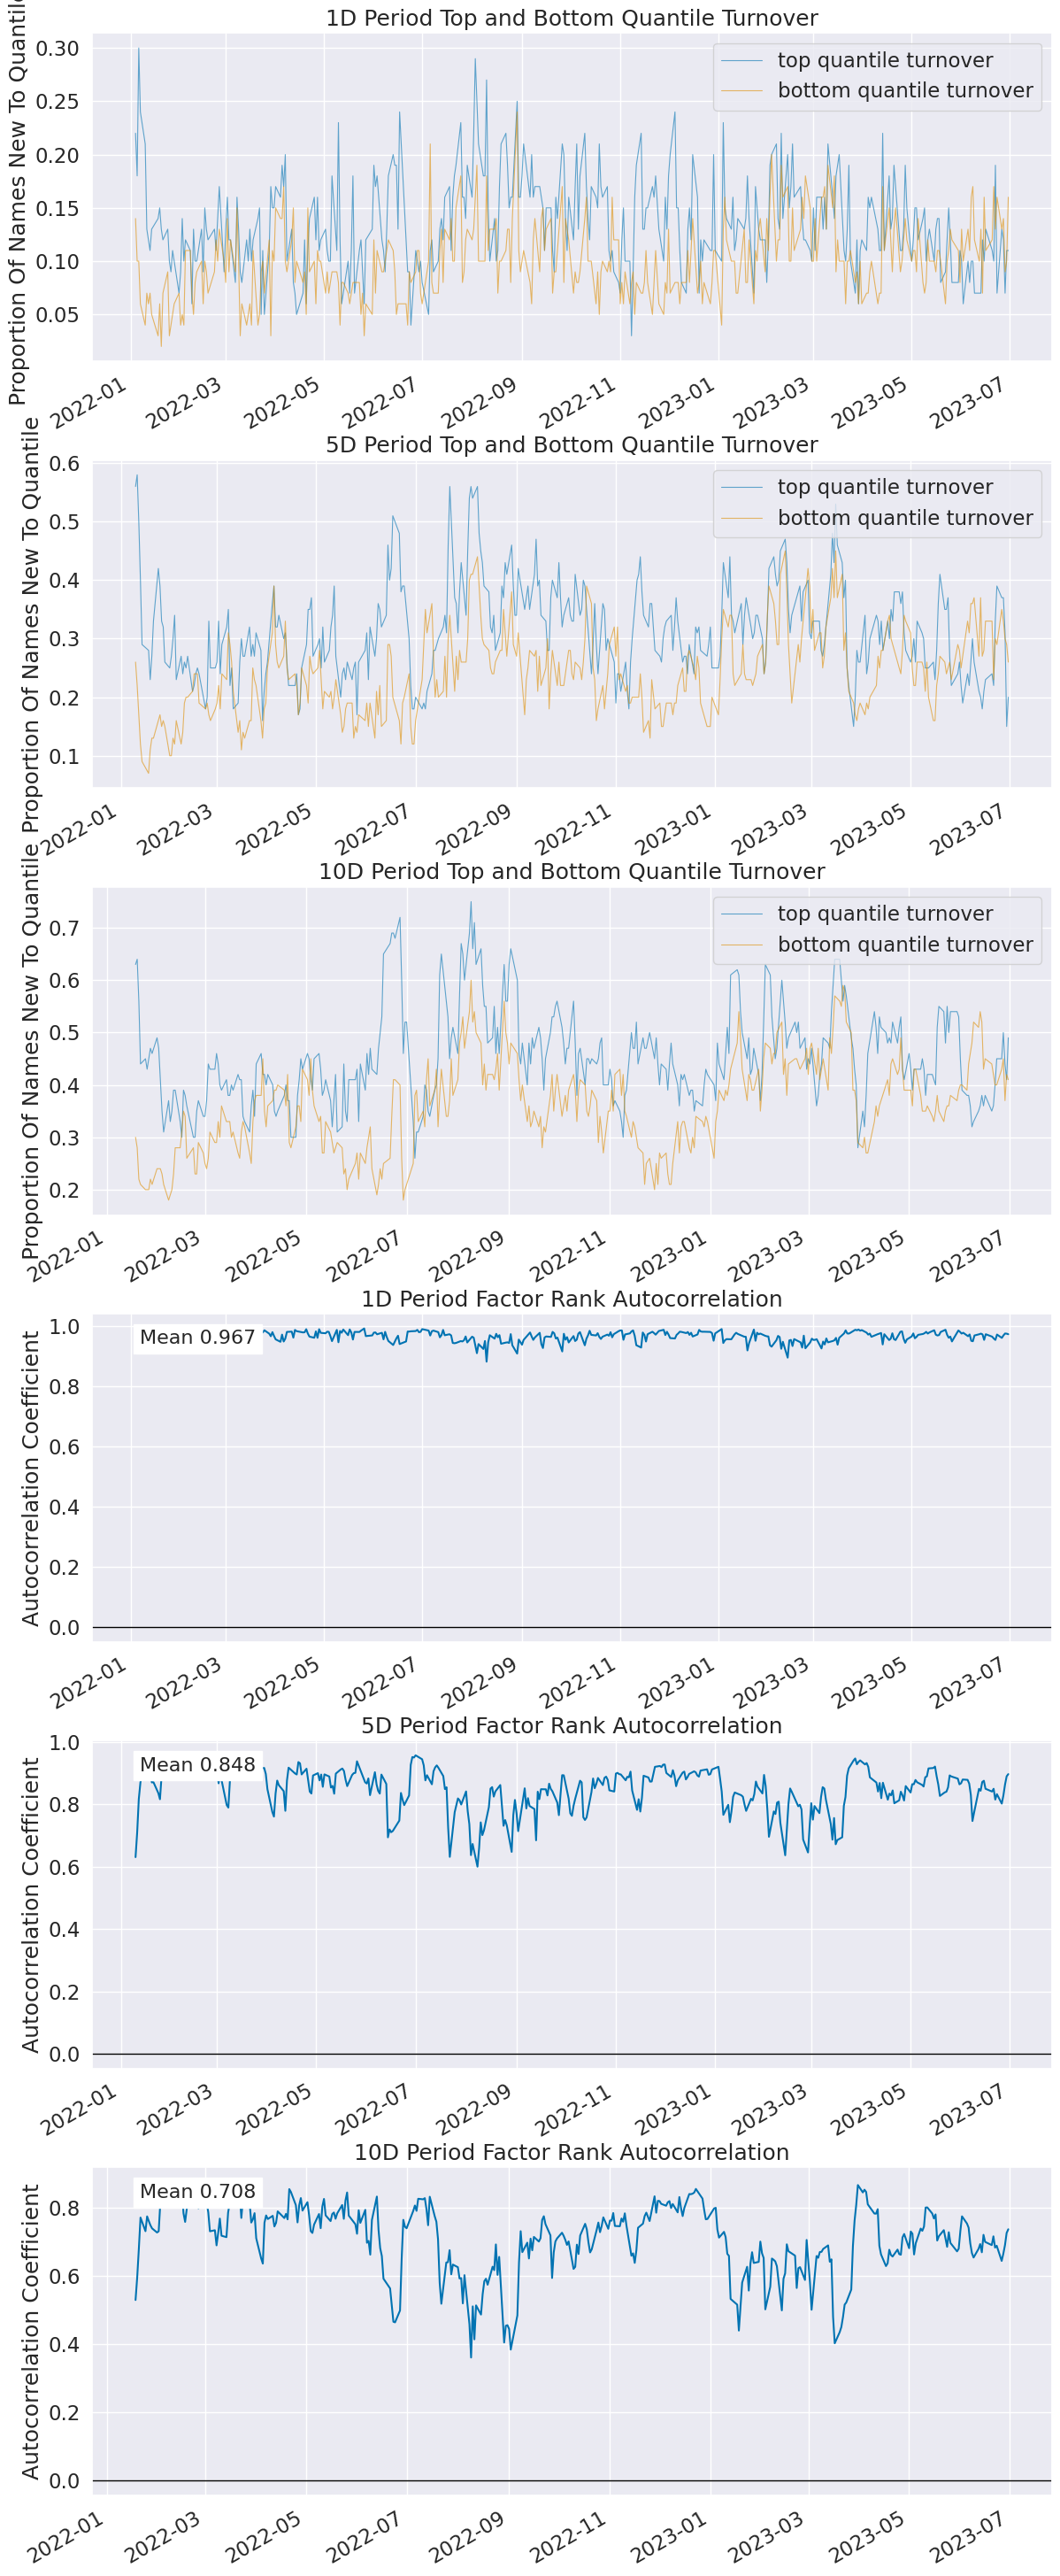

In [10]:
# Based on IC analysis, weight factors
# (Adjust these weights based on your IC results above)

weights = {
    'momentum_z': 0.4,
    'short_momentum_z': 0.2,
    'volatility_z': -0.3,  # Negative weight for low volatility
    'rsi_z': 0.1,
}

# Create combined score
combined_score = sum(factor_data[name] * weight for name, weight in weights.items())

print("Multi-Factor Combined Score:")
print(f"  Weights: {weights}")
print(f"\nAnalyzing combined factor...")

# Analyze combined factor
combined_clean = al.utils.get_clean_factor_and_forward_returns(
    factor=combined_score,
    prices=prices,
    quantiles=5,
    periods=(1, 5, 10),
    max_loss=0.35,
)

print("\n" + "="*80)
print("COMBINED MULTI-FACTOR ANALYSIS")
print("="*80 + "\n")

al.tears.create_full_tear_sheet(combined_clean)

## Factor Correlation Analysis

Understand how factors relate to avoid redundancy.

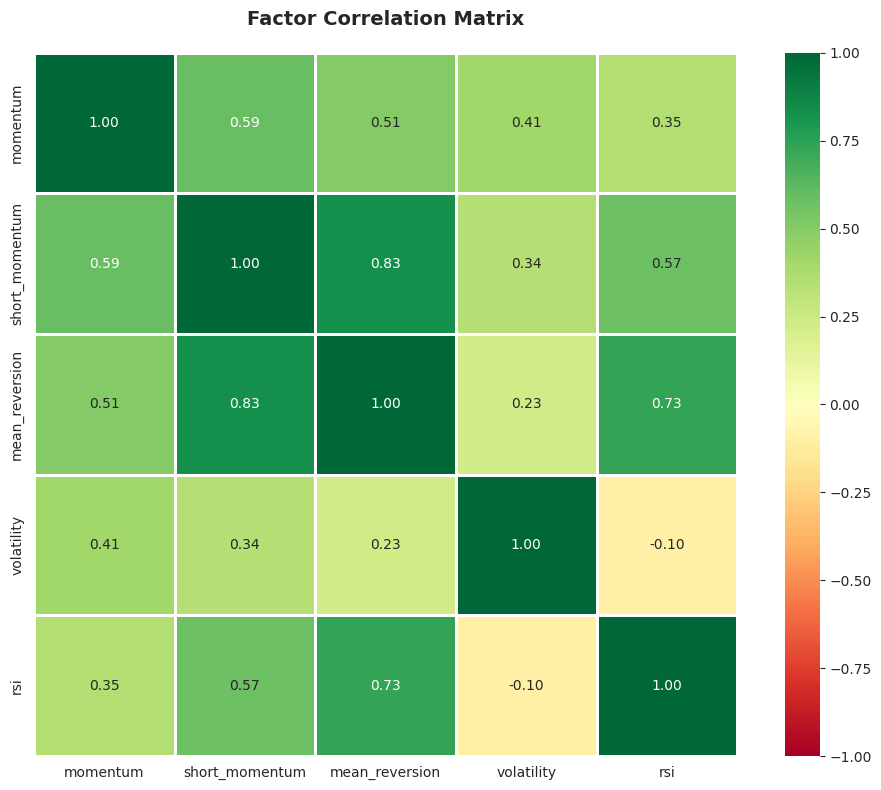


Factor Correlations:
                momentum  short_momentum  mean_reversion  volatility       rsi
momentum        1.000000        0.589449        0.507412    0.406979  0.350940
short_momentum  0.589449        1.000000        0.832253    0.341743  0.572190
mean_reversion  0.507412        0.832253        1.000000    0.233208  0.732883
volatility      0.406979        0.341743        0.233208    1.000000 -0.095173
rsi             0.350940        0.572190        0.732883   -0.095173  1.000000

Low correlation = factors provide diversified signals
High correlation = factors may be redundant


In [11]:
# Get latest cross-section
latest_date = factor_data.index.get_level_values(0).max()
latest_factors = factor_data.loc[latest_date]

# Calculate correlations
factor_corr = latest_factors[factors_to_test].corr()

# Plot
plt.figure(figsize=(10, 8))
sns.heatmap(
    factor_corr,
    annot=True,
    fmt='.2f',
    cmap='RdYlGn',
    center=0,
    vmin=-1,
    vmax=1,
    square=True,
    linewidths=1
)
plt.title('Factor Correlation Matrix', fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

print("\nFactor Correlations:")
print("="*60)
print(factor_corr)
print("\nLow correlation = factors provide diversified signals")
print("High correlation = factors may be redundant")

## Summary & Recommendations

Based on this analysis:

### Key Questions to Answer:

1. **Which individual factors are predictive?**
   - Look at Mean IC and t-statistics
   - IC > 0.05 with t-stat > 2 is good

2. **Are factors correlated?**
   - Low correlation = good diversification
   - High correlation = consider removing redundant factors

3. **Do composite factors improve performance?**
   - Compare IC of composite vs individual factors
   - Check Sharpe ratio of factor returns

4. **What are optimal factor weights?**
   - Can use IC-based weights
   - Or equal-weight uncorrelated factors
   - Consider inverse volatility weighting

### Next Steps:

1. **Optimize factor weights** - Use historical IC to determine weights
2. **Test stability** - Run on different time periods
3. **Account for costs** - Factor turnover analysis
4. **Build strategy** - Use top-ranked stocks in a portfolio
5. **Backtest** - Test full strategy with transaction costs

### Research Best Practices:

- Test on out-of-sample data
- Avoid overfitting (don't optimize too much)
- Consider fundamental reasons why factors work
- Monitor factor decay and regime changes
- Account for transaction costs and market impact